In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import resample

np.random.seed(101)
n = 1500

genders = ["Male", "Female", "Non-binary"]
school_types = ["Public", "Private", "International"]
income_levels = ["Low", "Medium", "High"]

data = pd.DataFrame({
    "Applicant_ID": range(1, n+1),
    "Gender": np.random.choice(genders, n, p=[0.45, 0.5, 0.05]),
    "School_Type": np.random.choice(school_types, n, p=[0.5, 0.35, 0.15]),
    "Income_Level": np.random.choice(income_levels, n, p=[0.4, 0.4, 0.2]),
    "GPA": np.round(np.random.uniform(2.0, 4.0, n), 2),
    "Extra_Curricular_Score": np.random.randint(0, 100, n)
})

# Introduce bias: Private & High income students more likely to get scholarships
data["Scholarship_Awarded"] = np.where(
    ((data["School_Type"] == "Private") & (data["GPA"] > 3.5)) |
    ((data["Income_Level"] == "High") & (data["Extra_Curricular_Score"] > 70)),
    np.random.choice([1, 0], n, p=[0.75, 0.25]),
    np.random.choice([1, 0], n, p=[0.45, 0.55])
)

data.head()

,Applicant_ID,Gender,School_Type,Income_Level,GPA,Extra_Curricular_Score,Scholarship_Awarded
0,1,Female,International,Low,3.09,68,1
1,2,Female,Public,Medium,3.90,3,0
2,3,Male,Public,Medium,2.45,8,1
3,4,Male,Public,Medium,3.94,1,1
4,5,Female,Private,Medium,3.43,88,0


Gender distribution:
 Gender
Female        0.496667
Male          0.455333
Non-binary    0.048000
Name: proportion, dtype: float64

School type distribution:
 School_Type
Public           0.500667
Private          0.364667
International    0.134667
Name: proportion, dtype: float64

Income level distribution:
 Income_Level
Low       0.390667
Medium    0.389333
High      0.220000
Name: proportion, dtype: float64


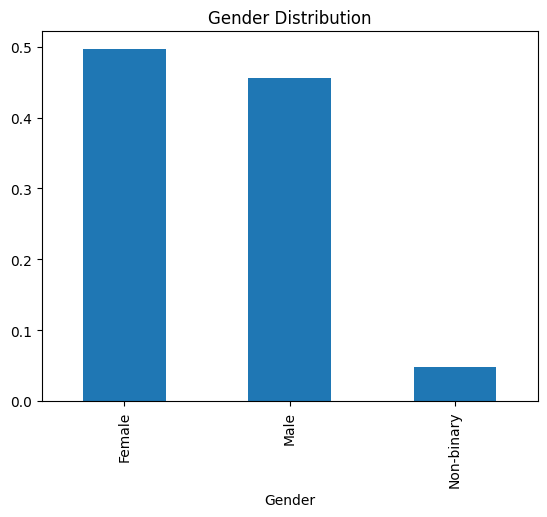

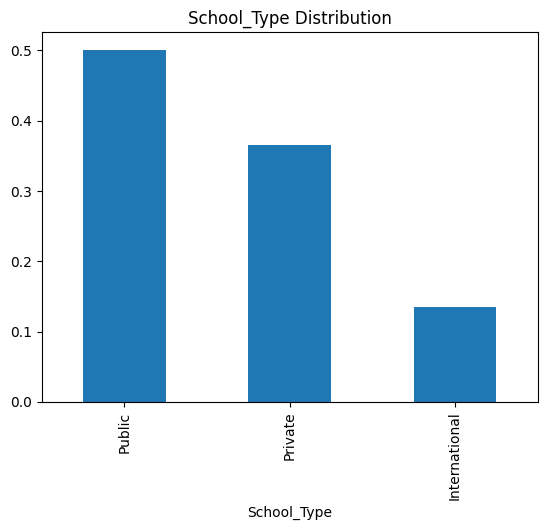

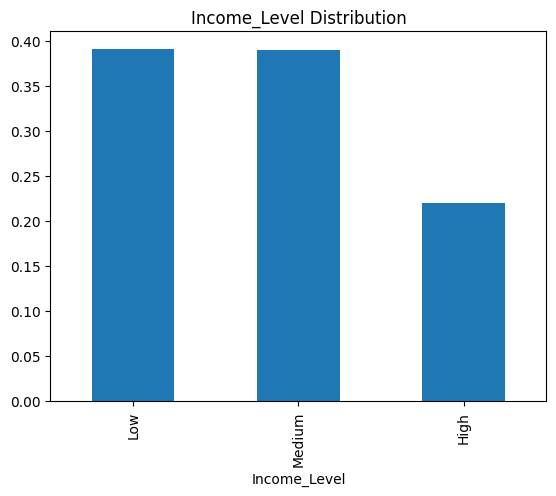

In [2]:
# Representation by sensitive attributes
print("Gender distribution:\n", data["Gender"].value_counts(normalize=True))
print("\nSchool type distribution:\n", data["School_Type"].value_counts(normalize=True))
print("\nIncome level distribution:\n", data["Income_Level"].value_counts(normalize=True))

# Plot
for col in ["Gender", "School_Type", "Income_Level"]:
    data[col].value_counts(normalize=True).plot(kind='bar', title=f"{col} Distribution")
    plt.show()


Scholarship rates by Gender:
 Gender
Female        0.528859
Male          0.462665
Non-binary    0.416667
Name: Scholarship_Awarded, dtype: float64


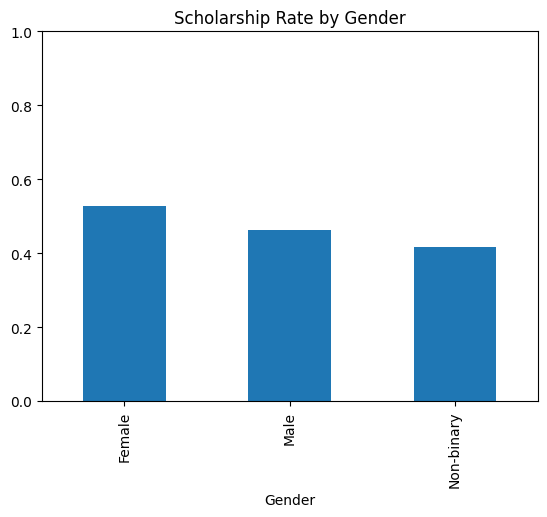


Scholarship rates by School_Type:
 School_Type
International    0.460396
Private          0.521024
Public           0.482024
Name: Scholarship_Awarded, dtype: float64


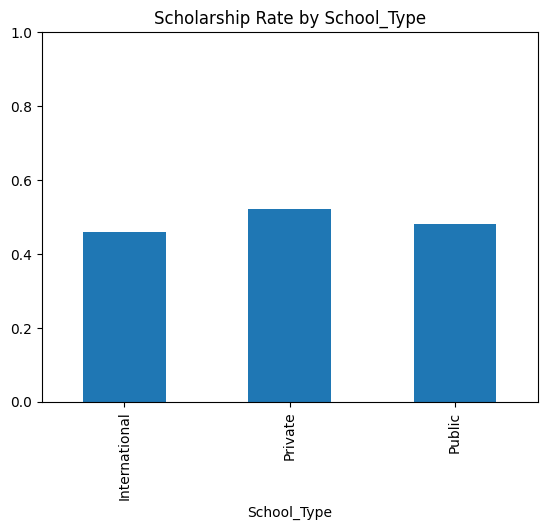


Scholarship rates by Income_Level:
 Income_Level
High      0.572727
Low       0.482935
Medium    0.458904
Name: Scholarship_Awarded, dtype: float64


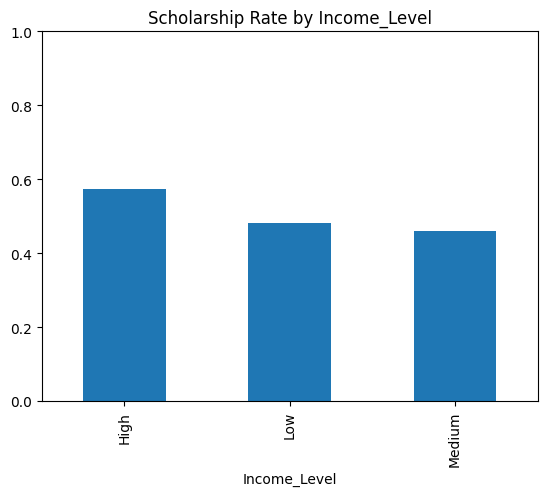

In [3]:
for col in ["Gender", "School_Type", "Income_Level"]:
    rates = data.groupby(col)["Scholarship_Awarded"].mean()
    print(f"\nScholarship rates by {col}:\n", rates)
    rates.plot(kind='bar', title=f"Scholarship Rate by {col}")
    plt.ylim(0,1)
    plt.show()

In [4]:
for col in ["Gender", "School_Type", "Income_Level"]:
    table = pd.crosstab(data[col], data["Scholarship_Awarded"])
    chi2, p, dof, exp = chi2_contingency(table)
    print(f"Chi-square test for {col}: p-value={p:.4f}")

Chi-square test for Gender: p-value=0.0181
Chi-square test for School_Type: p-value=0.2300
Chi-square test for Income_Level: p-value=0.0034


In [5]:
# Encode categorical features
X = pd.get_dummies(data.drop(columns=["Applicant_ID", "Scholarship_Awarded"]), drop_first=True)
y = data["Scholarship_Awarded"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LogisticRegression(solver='liblinear', max_iter=200)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print(f"Baseline accuracy: {accuracy_score(y_test, y_pred):.3f}")

Baseline accuracy: 0.509


In [6]:
def group_metrics(df, y_true, y_pred, group_col):
    res = {}
    for group in df[group_col].unique():
        idx = df[group_col] == group
        tn, fp, fn, tp = confusion_matrix(y_true[idx], y_pred[idx]).ravel()
        tpr = tp / (tp+fn) if (tp+fn) else 0
        fpr = fp / (fp+tn) if (fp+tn) else 0
        acc = (tp+tn) / len(idx)
        res[group] = {"TPR": tpr, "FPR": fpr, "Accuracy": acc}
    return pd.DataFrame(res)

df_test = X_test.copy()
df_test["Gender"] = data.loc[y_test.index, "Gender"]
df_test["School_Type"] = data.loc[y_test.index, "School_Type"]
df_test["Income_Level"] = data.loc[y_test.index, "Income_Level"]

print("\nMetrics by Gender:\n", group_metrics(df_test, y_test, y_pred, "Gender"))
print("\nMetrics by School_Type:\n", group_metrics(df_test, y_test, y_pred, "School_Type"))
print("\nMetrics by Income_Level:\n", group_metrics(df_test, y_test, y_pred, "Income_Level"))


Metrics by Gender:
               Male    Female  Non-binary
TPR       0.272727  0.661017    0.166667
FPR       0.287037  0.645455    0.222222
Accuracy  0.231111  0.260000    0.017778

Metrics by School_Type:
             Public   Private  International
TPR       0.483871  0.567010       0.181818
FPR       0.459459  0.525641       0.315789
Accuracy  0.233333  0.204444       0.071111

Metrics by Income_Level:
             Medium       Low      High
TPR       0.216867  0.453488  0.907407
FPR       0.202247  0.525253  0.871795
Accuracy  0.197778  0.191111  0.120000


In [11]:
# Balance by income level via upsampling minority categories
frames = []
max_size = data["Income_Level"].value_counts().max()

for lvl in data["Income_Level"].unique():
    subset = data[data["Income_Level"] == lvl]
    upsampled = resample(subset, replace=True, n_samples=max_size, random_state=42)
    frames.append(upsampled)

data_balanced = pd.concat(frames)

# Reset the index after upsampling to avoid duplicate labels
data_balanced = data_balanced.reset_index(drop=True)

print("Balanced income distribution:\n", data_balanced["Income_Level"].value_counts())

Balanced income distribution:
 Income_Level
Low       586
Medium    586
High      586
Name: count, dtype: int64


In [8]:
Xb = pd.get_dummies(data_balanced.drop(columns=["Applicant_ID", "Scholarship_Awarded"]), drop_first=True)
yb = data_balanced["Scholarship_Awarded"]

X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(Xb, yb, test_size=0.3, random_state=42)

model_b = LogisticRegression(solver='liblinear', max_iter=200)
model_b.fit(X_train_b, y_train_b)

y_pred_b = model_b.predict(X_test_b)
print(f"Balanced accuracy: {accuracy_score(y_test_b, y_pred_b):.3f}")

Balanced accuracy: 0.580


In [13]:
def demographic_parity(y_true, y_pred, groups):
    rates = pd.DataFrame({"pred": y_pred, "grp": groups}).groupby("grp")["pred"].mean()
    return rates.max() - rates.min()

def equal_opportunity(y_true, y_pred, groups):
    diffs = []
    for g in np.unique(groups):
        idx = groups == g
        tp = ((y_pred[idx] == 1) & (y_true[idx] == 1)).sum()
        fn = ((y_pred[idx] == 0) & (y_true[idx] == 1)).sum()
        tpr = tp / (tp + fn) if (tp+fn) else 0
        diffs.append(tpr)
    return max(diffs) - min(diffs)

def disparate_impact(y_true, y_pred, groups, privileged_group):
    rates = pd.DataFrame({"pred": y_pred, "grp": groups}).groupby("grp")["pred"].mean()
    if privileged_group not in rates:
        return None
    return rates.min() / rates[privileged_group]

In [14]:
# Baseline
dp_base = demographic_parity(y_test, y_pred, df_test["Income_Level"])
eo_base = equal_opportunity(y_test, y_pred, df_test["Income_Level"])
di_base = disparate_impact(y_test, y_pred, df_test["Income_Level"], "High")

# Balanced
df_test_b = X_test_b.copy()
# Use the reset index of data_balanced to get the original Income_Level for the test set
df_test_b["Income_Level"] = data_balanced.loc[y_test_b.index, "Income_Level"]

dp_bal = demographic_parity(y_test_b, y_pred_b, df_test_b["Income_Level"])
eo_bal = equal_opportunity(y_test_b, y_pred_b, df_test_b["Income_Level"])
di_bal = disparate_impact(y_test_b, y_pred_b, df_test_b["Income_Level"], "High")

print("Baseline Fairness Metrics (Income_Level):")
print(f"Demographic Parity Difference: {dp_base:.3f}")
print(f"Equal Opportunity Difference: {eo_base:.3f}")
print(f"Disparate Impact Ratio: {di_base:.3f}")

print("\nBalanced Fairness Metrics (Income_Level):")
print(f"Demographic Parity Difference: {dp_bal:.3f}")
print(f"Equal Opportunity Difference: {eo_bal:.3f}")
print(f"Disparate Impact Ratio: {di_bal:.3f}")

Baseline Fairness Metrics (Income_Level):
Demographic Parity Difference: 0.683
Equal Opportunity Difference: 0.691
Disparate Impact Ratio: 0.235

Balanced Fairness Metrics (Income_Level):
Demographic Parity Difference: 0.129
Equal Opportunity Difference: 0.090
Disparate Impact Ratio: 1.000
